In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 6)
rcParams['legend.fontsize'] = 16
rcParams['axes.labelsize'] = 16

In [2]:
r = np.linspace(0, 5, 100)

linear = r**2

huber = r**2
huber[huber > 1] = 2 * r[huber > 1] - 1

soft_l1 = 2 * (np.sqrt(1 + r**2) - 1)

cauchy = np.log1p(r**2)

arctan = np.arctan(r**2)

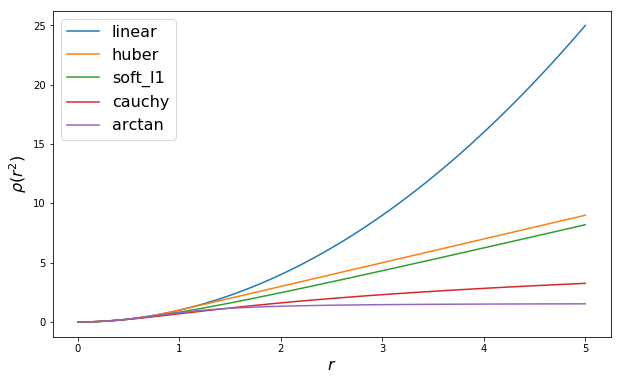

In [3]:
plt.plot(r, linear, label='linear')
plt.plot(r, huber, label='huber')
plt.plot(r, soft_l1, label='soft_l1')
plt.plot(r, cauchy, label='cauchy')
plt.plot(r, arctan, label='arctan')
plt.xlabel("$r$")
plt.ylabel(r"$\rho(r^2)$")
plt.legend(loc='upper left')

In [4]:
def generate_data(t, A, sigma, omega, noise=0, n_outliers=0, random_state=0):
    y = A * np.exp(-sigma * t) * np.sin(omega * t)
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(t.size)
    outliers = rnd.randint(0, t.size, n_outliers)
    error[outliers] *= 35
    return y + error

In [5]:
A = 2
sigma = 0.1
omega = 0.1 * 2 * np.pi
x_true = np.array([A, sigma, omega])

noise = 0.1

t_min = 0
t_max = 30

In [6]:
t_train = np.linspace(t_min, t_max, 30)
y_train = generate_data(t_train, A, sigma, omega, noise=noise, n_outliers=4)

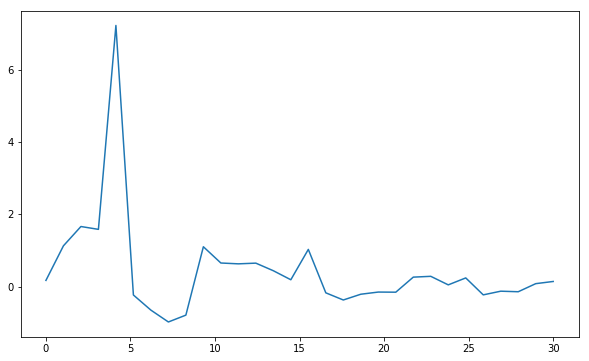

In [7]:
plt.plot(t_train, y_train)

In [8]:
def fun(x, t, y):
    return x[0] * np.exp(-x[1] * t) * np.sin(x[2] * t) - y

In [9]:
x0 = np.ones(3)

In [10]:
from scipy.optimize import least_squares

In [11]:
res_lsq = least_squares(fun, x0, args=(t_train, y_train))

In [14]:
res_robust = least_squares(fun, x0, loss='soft_l1', f_scale=0.1, args=(t_train, y_train))

In [15]:
t_test = np.linspace(t_min, t_max, 300)
y_test = generate_data(t_test, A, sigma, omega)

In [16]:
y_lsq = generate_data(t_test, *res_lsq.x)
y_robust = generate_data(t_test, *res_robust.x)

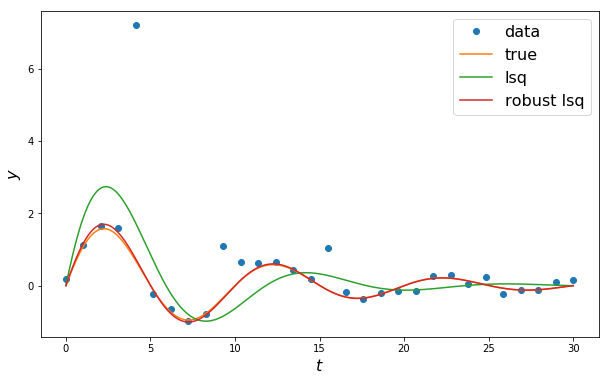

In [17]:
plt.plot(t_train, y_train, 'o', label='data')
plt.plot(t_test, y_test, label='true')
plt.plot(t_test, y_lsq, label='lsq')
plt.plot(t_test, y_robust, label='robust lsq')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend()

# Fitting with Outliers using Astropy

http://docs.astropy.org/en/stable/modeling/fitting.html

In [18]:
import numpy as np
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting
import scipy.stats as stats
from matplotlib import pyplot as plt

In [25]:
# Generate fake data with outliers
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
c = stats.bernoulli.rvs(0.35, size=x.shape)
y += (np.random.normal(0., 0.2, x.shape) +
      c*np.random.normal(3.0, 5.0, x.shape))
y_uncs = np.sqrt(np.square(np.full(x.shape, 0.2))
                 + c*np.square(np.full(x.shape,5.0)))
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)

In [23]:
# initialize fitters
fit = fitting.LevMarLSQFitter()
variance = np.ones(np.shape(x))
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip,
                                           niter=3, sigma=variance)

In [24]:
filtered_data, or_fitted_model = or_fit(g_init, x, y)
fitted_model = fit(g_init, x, y)

TypeError: Improper input: N=3 must not exceed M=2

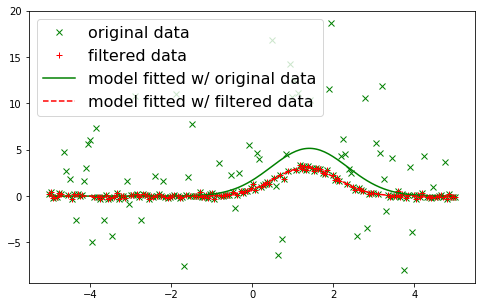

In [22]:
plt.figure(figsize=(8,5))
plt.plot(x, y, 'gx', label="original data")
plt.plot(x, filtered_data, 'r+', label="filtered data")
plt.plot(x, fitted_model(x), 'g-',
         label="model fitted w/ original data")
plt.plot(x, or_fitted_model(x), 'r--',
         label="model fitted w/ filtered data")
plt.legend(loc=2, numpoints=1)